In [29]:
from beam_show_ops import plot_beam, print_UVBeam

<a id='rhino_matlab'></a>
## RHINO Beam from matlab

Use the data from the original files. From the el and az, calculate points on an x/y grid and insert power values (if more than 1 value goes to an x/y point they are averaged). The matlab values are assumed to be dB so they are converted to values 10**(dB/10). Then the values are plotted on log scale.

There are positive and negative el in the matlab files. I only use el > =0.

The el/az have to be rotated because the beam is pointing at the horizon. This requires a rotation in 3-D space about an axis. After the rotation, the el/az are NOT regularly gridded. The gridding that is done for plotting purposes will shift each el/az to the nearest grid point without altering the power values. The next section will do it better by interpolating power values to a regular grid.

[0.000000e+00 6.123234e-17 1.000000e+00]
[1.5707963267948966, 0.0]
el shape (181,)
az shape (361,)
values shape (181, 361)


invalid value encountered in divide


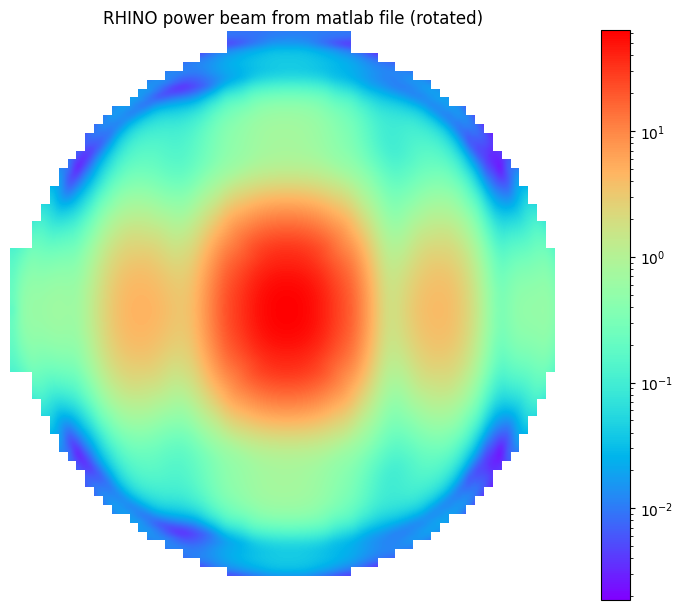

In [30]:
def rotate(X, theta, axis='x'):
  '''Rotate multidimensional array `X` `theta` degrees around axis `axis`'''
  c, s = np.cos(theta), np.sin(theta)
  if axis == 'x': return np.dot(X, np.array([
    [1.,  0,  0],
    [0 ,  c, -s],
    [0 ,  s,  c]
  ]))
  elif axis == 'y': return np.dot(X, np.array([
    [c,  0,  -s],
    [0,  1,   0],
    [s,  0,   c]
  ]))
  elif axis == 'z': return np.dot(X, np.array([
    [c, -s,  0 ],
    [s,  c,  0 ],
    [0,  0,  1.],
  ]))

def to_xyz(el, az):
    
    r = np.cos(el)
    x = r*np.sin(az)
    y = r*np.cos(az)  
    z = np.sin(el)

    return [x, y, z]

def to_el_az(xyz):
    el = np.arcsin(xyz[2])
    az = np.arctan2(xyz[0], xyz[1])
    return [el, az]


# Test rotation. Convert co-ords 0, 0 to xyz and rotate
v = to_xyz(0, 0)
th = np.deg2rad(-90)
v = rotate(v, th, axis="x")
print(v)
print(to_el_az(v))

# Load the original matlab files and apply rotation and grid and plot

with open("matlab_horn_351MHz_az.dat", "r") as f:
    az = np.deg2rad(np.array(f.readline()[:-1].split(","), dtype=float))

with open("matlab_horn_351MHz_el.dat", "r") as f:
    el = np.deg2rad(np.array(f.readline()[:-1].split(","), dtype=float))

values = np.loadtxt("matlab_horn_351MHz.dat")   # el by az
values = 10**(values/10)        # dB to power

print("el shape",el.shape)
print("az shape", az.shape)
print("values shape", values.shape)

all_az = []
all_el = []
all_values = []
# Grid the values
rotate_theta = np.deg2rad(-90)
grid = np.zeros((64, 64))    
nums = np.zeros((64, 64))     # For averaging
for i in range(len(el)):
    for j in range(len(az)):
        
        v = to_xyz(el[i], az[j])
        v = rotate(v, rotate_theta, axis="x")
        el_az = to_el_az(v)
        new_el = el_az[0]
        new_az = el_az[1]
        all_az.append(new_az)
        all_el.append(new_el)
        all_values.append(values[i, j])
        #new_el = el[i]
        #new_az = az[j]
        
        if new_el > 0:
            r = np.cos(new_el)
            x = r*np.sin(new_az)
            y = r*np.cos(new_az)  
    
            # convert the x/y points to a grid location. x/y can be -1 to 1
            gi = int(np.trunc(np.interp(x, [-1, 1], [0, 63])))
            gj = int(np.trunc(np.interp(y, [-1, 1], [0, 63])))
            grid[gi, gj] += values[i, j]
            nums[gi, gj] += 1

# Save the data in a raw format

np.savez("/tmp/all.npz", all_az=np.array(all_az), all_el=np.array(all_el), all_values=np.array(all_values))
grid = np.where(grid<=0, np.nan, grid/nums)

plt.figure(figsize=(8, 8))


ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("RHINO power beam from matlab file (rotated)")
plt.savefig("rhino_matlab")


## Regridding

Load the rotated el/az data from previous, but regrid the el/az on a regular grid, which will be needed to create a UVBeam. The el/az after rotation are NOT regularly gridded.

Create new files in Matlab format with the regdidded data.

invalid value encountered in divide


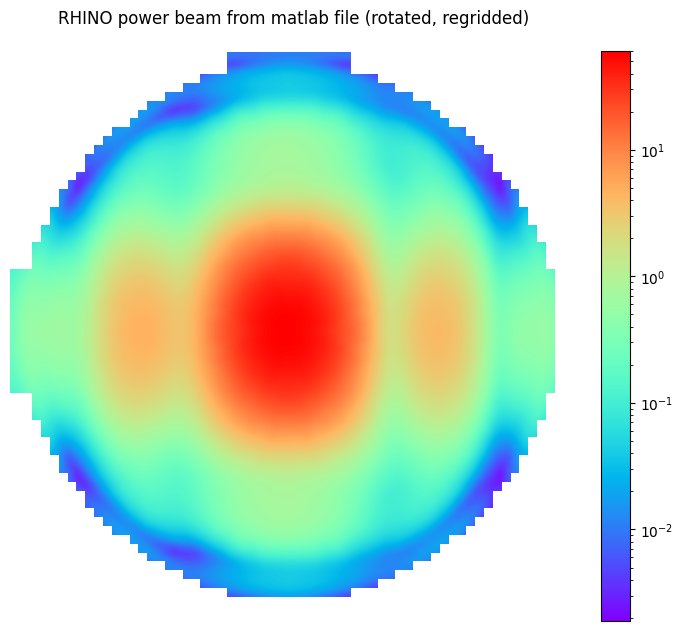

In [31]:
from scipy.interpolate import griddata

data = np.load("/tmp/all.npz")
az = np.rad2deg(data["all_az"])
el = np.rad2deg(data["all_el"])
power = data["all_values"]
values
points = np.column_stack((el, az))


xi_az = np.tile(np.arange(-180, 181, dtype=int), 181)
xi_el = np.repeat(np.arange(-90, 91, dtype=int), 361)
xi = np.column_stack((xi_el, xi_az))


interpolated_power = griddata(points, power, xi, method="nearest")

# Dump new files. Need to normalize the az/el to az/za with correct values around the circle
ip_grid = np.zeros((181, 361))
for i in range(len(xi)):
    # make the az go from 0 to 360
    az = xi[i][1]
    if az < 0: az += 360
    # convert el to za and make from 0 to 180
    za = 90-xi[i][0]                     # nothing else to do

    ip_grid[int(za), int(az)] = interpolated_power[i]

za = ",".join([ str(i) for i in range(181) ])
with open("./matlab_horn_351MHz_rot_za.dat", "w") as f:
    f.write(za+"\n")
az = ",".join([ str(i) for i in range(361) ])
with open("./matlab_horn_351MHz_rot_az.dat", "w") as f:
    f.write(az+"\n")

np.savetxt("matlab_horn_351MHz_rot.dat", ip_grid)
# ---------------------------------------------------

grid = np.zeros((64, 64))    
nums = np.zeros((64, 64))     # For averaging
for i in range(len(xi)):
        
        el = np.deg2rad(xi[i][0])
        az = np.deg2rad(xi[i][1])
        
        if el > 0:
            r = np.cos(el)
            x = r*np.sin(az)
            y = r*np.cos(az)  
    
            # convert the x/y points to a grid location. x/y can be -1 to 1
            gi = int(np.trunc(np.interp(x, [-1, 1], [0, 63])))
            gj = int(np.trunc(np.interp(y, [-1, 1], [0, 63])))
            grid[gi, gj] += interpolated_power[i]
            nums[gi, gj] += 1

grid = np.where(grid<=0, np.nan, grid/nums)

plt.figure(figsize=(8, 8))


ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("RHINO power beam from matlab file (rotated, regridded)\n")
plt.savefig("rhino_matlab")

#plt.colorbar(im,fraction=0.023, pad=0.04)


<a id='rhino_uvbeam'></a>
## RHINO Beam as UVBeam

Create a UVBeam object from the rotated, regridded matlab files. This is done with process_matlab.py. Then plot the UVBeam.

The UVBeam has been given 208 frequencies because that is used in further simulations. The beam has been made identical for every frequency (wrong).

The bandpass_array values change after plotting because of normalization.

[0.02881287 0.03232227 0.03437248]


invalid value encountered in divide


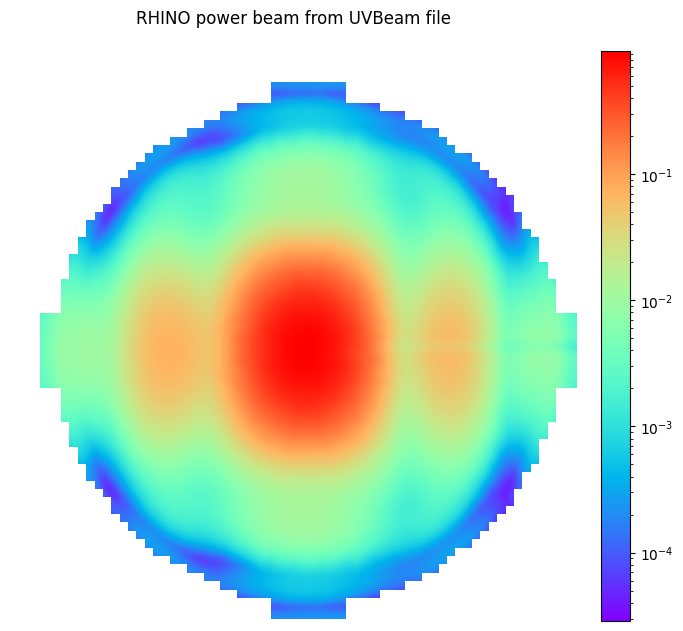

In [32]:
rhino = UVBeam()
rhino.read("/users/hgarsden/rhino-sim/rhino_matlab1.beamfits")
plot_beam(rhino, 60e6, "RHINO")

Print rhino beam parameters and some values.

In [33]:
print_UVBeam(rhino)

Naxes_vec 1
Nfreqs 280
antenna_type simple
bandpass_array shape (1, 280)
bandpass_array [[64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
  64.12166548 64.1216654